# HW3 Машинное обучение

In [43]:
import re
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import mlab


with open('anna.txt') as f:
    anna = f.read()
with open('sonnets.txt') as f:
    sonnets = f.read()

# предложения
anna_sentences = re.split(r'(?:[.]\s*){3}|[.?!]', anna)
sonnet_sentences = re.split(r'(?:[.]\s*){3}|[.?!]', sonnets)
print(len(anna_sentences))
len(sonnet_sentences)

21499


1378

In [19]:
# длины слов
def lenwords(sentence):
    return [len(word.strip('.,!?()-–"/1234567890')) for word in sentence.split()]
        
# число различных букв в предложении
def diff_letters(sentence):
    letters = set()
    for word in sentence.split():
        word = word.strip('.,!?()-–"/1234567890')
        letters = letters | set(word)
    return len(letters)

# число гласных в словах предложения
def sent_word_vowels(sentence):
    counts = []
    vowels = set('аеёиоуыэюяАЕЁИОУЫЭЮЯ')
    for word in sentence.split():
        count = 0
        for letter in word:
            if letter in vowels:
                count += 1
        counts.append(count)
    return counts

# число гласных в предложении
def sent_vowels(sentence):
    return sum(sent_word_vowels(sentence))

Создаем массивы с данными для корпусов. В массивах:
- длина предложения в буквах,
- число различных букв в предложении,
- число гласных в предложении,
- медиана числа букв в слове,
- медиана числа гласных в слове.

In [20]:
def create_data(sentences):
    data = [(sum(lenwords(sentence)),
             diff_letters(sentence),
             sent_vowels(sentence),
             np.median(lenwords(sentence)),
             np.median(sent_word_vowels(sentence))) 
            for sentence in sentences if len(lenwords(sentence)) > 0]
    return np.array(data)
    
anna_data = create_data(anna_sentences)
print(anna_data)
sonnets_data = create_data(sonnet_sentences)
print(sonnets_data)

[[ 142.    41.    59.     5.     2. ]
 [  26.    17.     9.     4.     2. ]
 [ 105.    31.    42.     3.     1. ]
 ..., 
 [  89.    22.    42.     3.     1.5]
 [ 409.    30.   170.     4.     2. ]
 [   5.     5.     2.     0.     0. ]]
[[  46.    24.    21.     4.     1. ]
 [  55.    22.    21.     5.5    2. ]
 [ 104.    30.    42.     4.     2. ]
 ..., 
 [  18.    13.     7.     5.     2. ]
 [  60.    24.    21.     3.     1. ]
 [  67.    24.    21.     7.     2. ]]


Посмотрим на простые графики поппарных распределений фич для анны и сонетов.

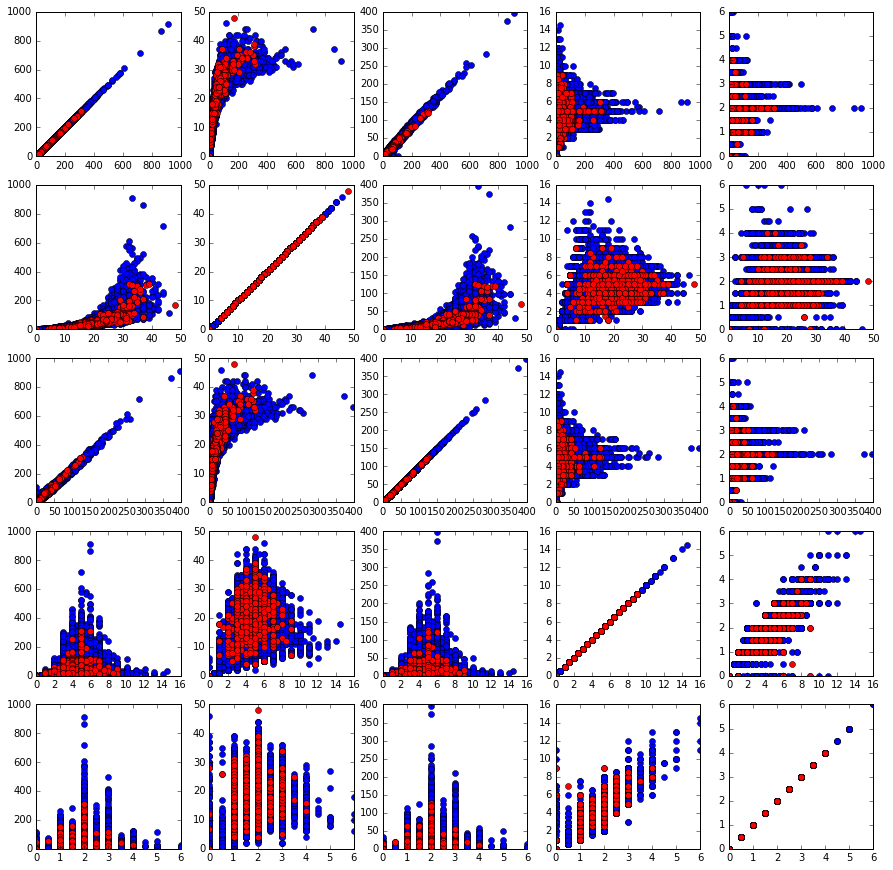

In [21]:
%matplotlib inline
from matplotlib import pyplot as plt


def plot_data(data1, data2):
    plt.figure(figsize=(15,15))
    n_col = data1.shape[1]
    graph_count = 1
    for i in range(n_col):
        for j in range(n_col):
            plt.subplot(n_col, n_col, graph_count)
            plt.plot(data1[:,i], data1[:,j], 'ob',
                     data2[:,i], data2[:,j], 'or')
            graph_count += 1
    plt.show()
    
plot_data(anna_data, sonnets_data)

В общем ничего особенного. Пара <i>длина предложения в буквах/число гласных в предложении</i> сильно коррелируют, а также пара <i>медиана числа букв в слове/медиана числа гласных в слове</i>. Число различных букв быстро растет, а потом "стремится" к числу букв в алфавите (пары <i>длина предложения в буквах/число различных букв в предложении</i> и <i>число различных букв в предложении/число гласных в предложении</i>).

Фичи сонетов практически всегда находятся "внутри" анны, за исключением нескольких аутлаеров. По некоторым фичам – длина предложения в буквах, число гласных в предложении – можно просто отделить длинные предложения анны. Например, не бывает предложений сонетов с длиной в буквах больше ~400 и количеством гласных больше ~140. По другим фичам отделить сложнее, но разброс у анны всегда больше.

Посмотрим на главные компоненты.

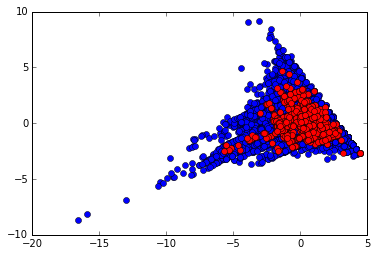

In [22]:
from matplotlib import mlab


data = np.vstack((anna_data, sonnets_data))
p = mlab.PCA(data, True)
N = len(anna_data)
plt.plot(p.Y[:N,0], p.Y[:N,1], 'ob', p.Y[N:,0], p.Y[N:,1], 'or')

Опять видим, что главные компоненты не особенно помогают. Хотя крайние, "разбросанные" предложения анны отделить можно, данные в центре распределения неразличимы.

Сделаем классификатор.

In [46]:
from sklearn import grid_search, svm


values = np.array([1] * len(anna_data) + [2] * len(sonnets_data))
print(len(anna_data))
print(len(sonnets_data))
val_data = np.c_[values, data]
val_data


21233
1360


array([[   1.,  142.,   41.,   59.,    5.,    2.],
       [   1.,   26.,   17.,    9.,    4.,    2.],
       [   1.,  105.,   31.,   42.,    3.,    1.],
       ..., 
       [   2.,   18.,   13.,    7.,    5.,    2.],
       [   2.,   60.,   24.,   21.,    3.,    1.],
       [   2.,   67.,   24.,   21.,    7.,    2.]])

In [24]:
parameters = {'C': (.1, .5, 1.0, 1.5, 1.7, 2.0)}
gs = grid_search.GridSearchCV(svm.LinearSVC(), parameters)
gs.fit(val_data[:, 1:], val_data[:, 0])
print('Best result is', gs.best_score_)
print('Best C is', gs.best_estimator_.C)

Best result is 0.939715841189749
Best C is 0.5


In [25]:
clf = svm.LinearSVC(C=gs.best_estimator_.C)
clf.fit(val_data[::2, 1:], val_data[::2, 0])

LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [48]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

wrong = 0
#for obj in val_data[1::2, :]:
#    label = clf.predict(obj[1:])
#    if label != obj[0] and wrong < 10:
#        i = np.where(val_data == obj)
#        print(i)
#        print('Пример ошибки машины: class = ', obj[0], ', label = ', label, ', экземпляр ', obj[1:])
#        wrong += 1
#    if wrong > 10:
#        break

all_sent = anna_sentences + sonnet_sentences

for i in range(1, len(val_data), 2):
#for i in range(1, 20, 2):
    label = clf.predict(val_data[i, 1:])
    if label != val_data[i, 0] and wrong < 10:
        print(i)
        print('Пример ошибки машины: class = ', val_data[i, 0], ', label = ', label, ', экземпляр ', val_data[i, 1:])
        wrong += 1
    if wrong > 10:
        break

1053
Пример ошибки машины: class =  1.0 , label =  [ 2.] , экземпляр  [ 107.    25.     0.     5.5    0. ]
16123
Пример ошибки машины: class =  1.0 , label =  [ 2.] , экземпляр  [ 75.   30.    6.    3.5   0. ]
16357
Пример ошибки машины: class =  1.0 , label =  [ 2.] , экземпляр  [ 80.  35.  16.   5.   0.]
21233
Пример ошибки машины: class =  2.0 , label =  [ 1.] , экземпляр  [ 46.  24.  21.   4.   1.]
21235
Пример ошибки машины: class =  2.0 , label =  [ 1.] , экземпляр  [ 104.   30.   42.    4.    2.]
21237
Пример ошибки машины: class =  2.0 , label =  [ 1.] , экземпляр  [ 50.  24.  20.   5.   3.]
21239
Пример ошибки машины: class =  2.0 , label =  [ 1.] , экземпляр  [ 51.   23.   20.    6.5   2. ]
21241
Пример ошибки машины: class =  2.0 , label =  [ 1.] , экземпляр  [ 16.   13.    6.    3.5   1. ]
21243
Пример ошибки машины: class =  2.0 , label =  [ 1.] , экземпляр  [ 50.  23.  20.   5.   2.]
21245
Пример ошибки машины: class =  2.0 , label =  [ 1.] , экземпляр  [ 53.   23.   20. 

Забавная первая ошибка в предложении без (кириллических?) гласных, которое классификатор попытался записать в сонеты. Попыталась вывести собственно предложения, которые ошибочно классифицируются, но у нас изменилась нумерация (не считаются пустые предложения), поэтому просто их вывести не получается. Но явно видно, что большинство ошибок делается при классификации сонетов, что не удивительно, потому что их очень мало по сравнению с анной – выборка не сбалансирована.